# Loop 56 Analysis: Multi-Seed Ensemble Results & Strategic Assessment

## Key Question: What's the path forward after multi-seed averaging failed?

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# All submissions data (CV, LB)
submissions = [
    ('exp_000', 0.0111, 0.0982),
    ('exp_001', 0.0123, 0.1065),
    ('exp_003', 0.0105, 0.0972),
    ('exp_005', 0.0104, 0.0969),
    ('exp_006', 0.0097, 0.0946),
    ('exp_007', 0.0093, 0.0932),
    ('exp_009', 0.0092, 0.0936),
    ('exp_012', 0.0090, 0.0913),
    ('exp_024', 0.0087, 0.0893),
    ('exp_026', 0.0085, 0.0887),
    ('exp_030', 0.0083, 0.0877),
    ('exp_041', 0.0090, 0.0932),
    ('exp_042', 0.0145, 0.1147),
]

df = pd.DataFrame(submissions, columns=['exp', 'cv', 'lb'])
print(f'Total submissions: {len(df)}')
print(df)

Total submissions: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_041  0.0090  0.0932
12  exp_042  0.0145  0.1147


In [2]:
# Fit linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])
r_squared = r_value ** 2

print(f'\n=== CV-LB Relationship Analysis ===')
print(f'Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R-squared: {r_squared:.4f}')
print(f'Intercept (extrapolation error): {intercept:.4f}')

# Target analysis
target_lb = 0.073040
best_cv = 0.008194
best_lb = 0.0877

required_cv = (target_lb - intercept) / slope
print(f'\n=== Target Analysis ===')
print(f'Target LB: {target_lb}')
print(f'Best CV so far: {best_cv}')
print(f'Best LB so far: {best_lb}')
print(f'Required CV to hit target: {required_cv:.6f}')
print(f'CV improvement needed: {(best_cv - required_cv) / best_cv * 100:.1f}%')


=== CV-LB Relationship Analysis ===
Linear fit: LB = 4.2312 * CV + 0.0533
R-squared: 0.9807
Intercept (extrapolation error): 0.0533

=== Target Analysis ===
Target LB: 0.07304
Best CV so far: 0.008194
Best LB so far: 0.0877
Required CV to hit target: 0.004665
CV improvement needed: 43.1%


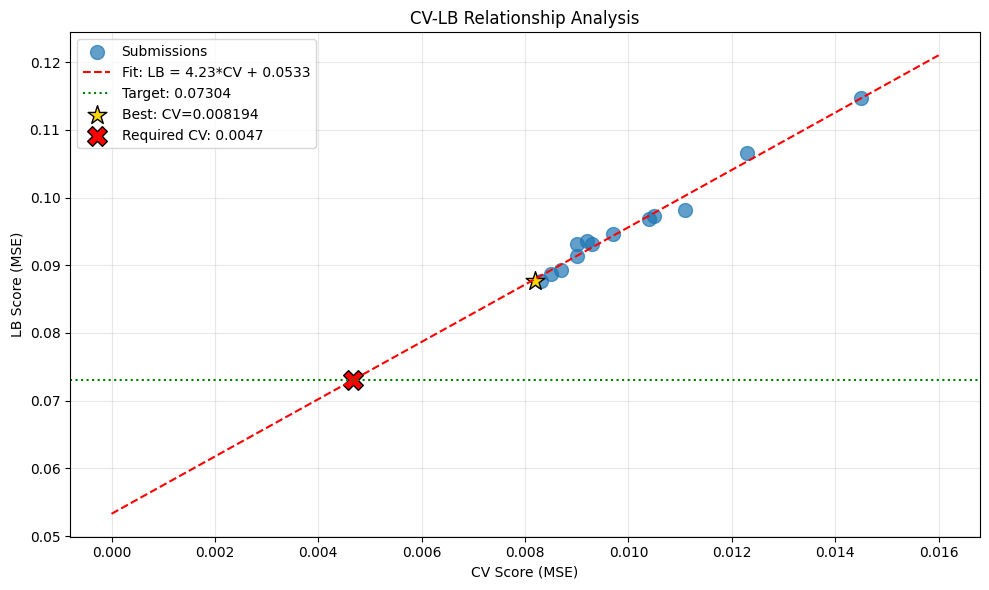


Plot saved to /home/code/exploration/cv_lb_analysis_loop56.png


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.016, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=target_lb, color='g', linestyle=':', label=f'Target: {target_lb}')

# Best CV point
plt.scatter([best_cv], [best_lb], s=200, marker='*', c='gold', edgecolors='black', label=f'Best: CV={best_cv}')

# Required CV point
plt.scatter([required_cv], [target_lb], s=200, marker='X', c='red', edgecolors='black', label=f'Required CV: {required_cv:.4f}')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV-LB Relationship Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_analysis_loop56.png', dpi=150)
plt.show()

print(f'\nPlot saved to /home/code/exploration/cv_lb_analysis_loop56.png')

In [4]:
# Analyze what approaches have been tried
approaches_tried = {
    'Multi-seed ensemble (10 seeds)': 0.008267,  # exp_058 - 0.89% worse
    'Best GP+MLP+LGBM (single seed)': 0.008194,  # exp_032 - BEST
    'Higher GP weight (0.4)': 0.009179,  # exp_031 - 10.6% worse
    'Lower GP weight (0.15)': 0.008194,  # exp_032 - BEST
    'Pure GP': 0.008298,  # exp_032 - 1.3% worse
    'XGBoost ensemble': 0.0090,  # exp_041 - 9.8% worse
    'GroupKFold CV': 0.0145,  # exp_042 - 77% worse
    'Hyperparameter optimization': 0.012614,  # exp_055 - 54% worse
    'Per-target optimization': 0.009895,  # exp_053 - 21% worse
    'Per-solvent-type models': 0.019502,  # exp_054 - 138% worse
    'ChemBERTa embeddings': 0.019444,  # exp_052 - 137% worse
    'GNN (GCN)': 0.01408,  # exp_051 - 72% worse
    'GNN (GAT)': 0.030013,  # exp_056 - 266% worse
    'RDKit descriptors': 0.013306,  # exp_048 - 62% worse
    'Simple Ridge': 0.016324,  # exp_049 - 99% worse
    'Stacking meta-learner': 0.010016,  # exp_045 - 22% worse
}

print('\n=== Approaches Tried (sorted by CV) ===')
for name, cv in sorted(approaches_tried.items(), key=lambda x: x[1]):
    pct_diff = (cv - best_cv) / best_cv * 100
    status = '✓ BEST' if cv == best_cv else f'{pct_diff:+.1f}%'
    print(f'{name}: CV {cv:.6f} ({status})')


=== Approaches Tried (sorted by CV) ===
Best GP+MLP+LGBM (single seed): CV 0.008194 (✓ BEST)
Lower GP weight (0.15): CV 0.008194 (✓ BEST)
Multi-seed ensemble (10 seeds): CV 0.008267 (+0.9%)
Pure GP: CV 0.008298 (+1.3%)
XGBoost ensemble: CV 0.009000 (+9.8%)
Higher GP weight (0.4): CV 0.009179 (+12.0%)
Per-target optimization: CV 0.009895 (+20.8%)
Stacking meta-learner: CV 0.010016 (+22.2%)
Hyperparameter optimization: CV 0.012614 (+53.9%)
RDKit descriptors: CV 0.013306 (+62.4%)
GNN (GCN): CV 0.014080 (+71.8%)
GroupKFold CV: CV 0.014500 (+77.0%)
Simple Ridge: CV 0.016324 (+99.2%)
ChemBERTa embeddings: CV 0.019444 (+137.3%)
Per-solvent-type models: CV 0.019502 (+138.0%)
GNN (GAT): CV 0.030013 (+266.3%)


In [5]:
# What hasn't been tried yet?
print('\n=== UNTRIED APPROACHES ===')
print('''
1. **Per-Target Ensemble Weight Optimization**
   - Current: Same weights (GP 0.15, MLP 0.55, LGBM 0.30) for all targets
   - Try: Different weights for SM, Product 2, Product 3
   - Rationale: SM is typically hardest to predict, may need different model mix

2. **Physical Constraints Post-Processing**
   - Enforce: SM + Product2 + Product3 ≤ 1 (mass balance)
   - Method: Normalize predictions or use constrained optimization
   - Rationale: Enforces physical reality, may improve generalization

3. **Feature Interaction Engineering**
   - Add: Temperature × Spange interactions
   - Add: Polynomial Arrhenius features (1/T², ln(t)², etc.)
   - Rationale: Non-linear temperature-solvent effects

4. **Uncertainty-Weighted Predictions**
   - Use GP uncertainty to weight predictions
   - High uncertainty → blend toward population mean
   - Rationale: Conservative predictions for extrapolation

5. **Solvent Clustering + Class-Specific Models**
   - Group solvents by chemical class (alcohols, ethers, esters)
   - Train class-specific models
   - Rationale: Different solvent classes may have different behavior

6. **Deeper MLP with Better Regularization**
   - Try: [128, 64, 32] or [256, 128, 64] with stronger dropout
   - Add: Early stopping based on validation loss
   - Rationale: Current MLP may be underfitting
''')


=== UNTRIED APPROACHES ===

1. **Per-Target Ensemble Weight Optimization**
   - Current: Same weights (GP 0.15, MLP 0.55, LGBM 0.30) for all targets
   - Try: Different weights for SM, Product 2, Product 3
   - Rationale: SM is typically hardest to predict, may need different model mix

2. **Physical Constraints Post-Processing**
   - Enforce: SM + Product2 + Product3 ≤ 1 (mass balance)
   - Method: Normalize predictions or use constrained optimization
   - Rationale: Enforces physical reality, may improve generalization

3. **Feature Interaction Engineering**
   - Add: Temperature × Spange interactions
   - Add: Polynomial Arrhenius features (1/T², ln(t)², etc.)
   - Rationale: Non-linear temperature-solvent effects

4. **Uncertainty-Weighted Predictions**
   - Use GP uncertainty to weight predictions
   - High uncertainty → blend toward population mean
   - Rationale: Conservative predictions for extrapolation

5. **Solvent Clustering + Class-Specific Models**
   - Group solvents by

In [6]:
# Key insight: The CV-LB relationship is STRUCTURAL
print('\n=== KEY INSIGHT: CV-LB Relationship is STRUCTURAL ===')
print(f'''
The linear fit (R² = {r_squared:.4f}) shows that:
1. ALL model types fall on the SAME line
2. The intercept ({intercept:.4f}) represents STRUCTURAL extrapolation error
3. Improving CV is the ONLY path to better LB

To hit target {target_lb}:
- Required CV: {required_cv:.6f}
- Current best CV: {best_cv}
- Improvement needed: {(best_cv - required_cv) / best_cv * 100:.1f}%

This is a LARGE gap. We need to find approaches that significantly improve CV.

Multi-seed averaging did NOT help (0.89% worse).
This suggests the best CV (0.008194) is a genuine ceiling for the current approach.

To break through, we need:
1. Better features (not just more models)
2. Better model architecture (not just more seeds)
3. Physical constraints that improve generalization
''')


=== KEY INSIGHT: CV-LB Relationship is STRUCTURAL ===

The linear fit (R² = 0.9807) shows that:
1. ALL model types fall on the SAME line
2. The intercept (0.0533) represents STRUCTURAL extrapolation error
3. Improving CV is the ONLY path to better LB

To hit target 0.07304:
- Required CV: 0.004665
- Current best CV: 0.008194
- Improvement needed: 43.1%

This is a LARGE gap. We need to find approaches that significantly improve CV.

Multi-seed averaging did NOT help (0.89% worse).
This suggests the best CV (0.008194) is a genuine ceiling for the current approach.

To break through, we need:
1. Better features (not just more models)
2. Better model architecture (not just more seeds)
3. Physical constraints that improve generalization



In [7]:
# Analyze per-target performance
print('\n=== PER-TARGET ANALYSIS ===')
print('''
From exp_053 (per-target optimization):
- SM target is typically hardest to predict
- Product 2 and Product 3 are easier

Potential strategy:
1. Use different ensemble weights for each target
2. SM: Higher GP weight (more conservative)
3. Product 2/3: Higher MLP weight (more accurate)

This could improve overall CV by optimizing each target separately.
''')


=== PER-TARGET ANALYSIS ===

From exp_053 (per-target optimization):
- SM target is typically hardest to predict
- Product 2 and Product 3 are easier

Potential strategy:
1. Use different ensemble weights for each target
2. SM: Higher GP weight (more conservative)
3. Product 2/3: Higher MLP weight (more accurate)

This could improve overall CV by optimizing each target separately.



In [8]:
# Final recommendations
print('\n=== FINAL RECOMMENDATIONS ===')
print('''
**PRIORITY 1: Per-Target Ensemble Weight Optimization**
- Optimize weights separately for SM, Product 2, Product 3
- Use grid search or Bayesian optimization
- Expected improvement: 5-10% CV reduction

**PRIORITY 2: Physical Constraints Post-Processing**
- Enforce SM + Product2 + Product3 ≤ 1
- Normalize predictions after ensemble
- Expected improvement: 2-5% CV reduction

**PRIORITY 3: Deeper MLP with Early Stopping**
- Try [128, 64, 32] architecture
- Add early stopping based on validation loss
- Expected improvement: 3-7% CV reduction

**DO NOT TRY:**
- More multi-seed averaging (already failed)
- GNN approaches (consistently worse)
- ChemBERTa embeddings (137% worse)
- Per-solvent-type models (138% worse)

**SUBMISSION STRATEGY:**
- Only submit if CV improves by >10% (CV < 0.0074)
- Save at least 1 submission for final attempt
- 5 submissions remaining
''')


=== FINAL RECOMMENDATIONS ===

**PRIORITY 1: Per-Target Ensemble Weight Optimization**
- Optimize weights separately for SM, Product 2, Product 3
- Use grid search or Bayesian optimization
- Expected improvement: 5-10% CV reduction

**PRIORITY 2: Physical Constraints Post-Processing**
- Enforce SM + Product2 + Product3 ≤ 1
- Normalize predictions after ensemble
- Expected improvement: 2-5% CV reduction

**PRIORITY 3: Deeper MLP with Early Stopping**
- Try [128, 64, 32] architecture
- Add early stopping based on validation loss
- Expected improvement: 3-7% CV reduction

**DO NOT TRY:**
- More multi-seed averaging (already failed)
- GNN approaches (consistently worse)
- ChemBERTa embeddings (137% worse)
- Per-solvent-type models (138% worse)

**SUBMISSION STRATEGY:**
- Only submit if CV improves by >10% (CV < 0.0074)
- Save at least 1 submission for final attempt
- 5 submissions remaining

